In [1]:
from gerrychain import Graph

In [27]:
from gerrychain import Graph
import os

filepath = '/Users/cherr/anaconda-gurobi/gurobi classes/'
filename = 'Iowa_county.json'

# Verify if the file is there at the given location.
file_path = os.path.join(filepath, filename)
if os.path.exists(file_path):
    # Proceed to read the file if it exists.
    Gr = Graph.from_json(file_path)
     # Use the graph to perform operations.
else:
    print(f"File '{filename}' not found in the specified directory.")


In [5]:
for node in Gr.nodes:
    Gr.nodes[node]['TOTPOP'] = Gr.nodes[node]['P0010001']


In [6]:
# Let us apply a population deviation of 1% (+/-0.5%).
deviation = 0.01

import math
k = 4          # of districts
total_population = sum( Gr.nodes[node]['TOTPOP'] for node in Gr.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 793605 and U = 801580 and k = 4


In [7]:
import gurobipy as gp
from gurobipy import GRB

# create model 
model = gp.Model()

# create variables
a = model.addVars(G.nodes, k, vtype=GRB.BINARY) # When county i is allocated to district j, x[i,j] = 1.
b = model.addVars(G.edges, vtype=GRB.BINARY)    # When edge {u,v} is sliced, y[u,v] = 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10


In [8]:
model.setObjective(gp.quicksum(Gr.edges[u, v]['shared_perim'] * b[u, v] for u, v in Gr.edges), GRB.MINIMIZE)


In [10]:
# add Constraint such that each county is allocated to one district
model.addConstrs(gp.quicksum(a[i, j] for j in range(k)) == 1 for i in Gr.nodes)

# add Constraints such that each district has population at least L and at most U
for j in range(k):
    model.addConstr(gp.quicksum(Gr.nodes[i]['TOTPOP'] * a[i, j] for i in Gr.nodes) >= L)
    model.addConstr(gp.quicksum(Gr.nodes[i]['TOTPOP'] * a[i, j] for i in Gr.nodes) <= U)

# add Constraints to Define cut edges based on district allocations
for u, v in Gr.edges:
    for j in range(k):
        model.addConstr(a[u, j] - a[v, j] <= b[u, v])

model.update()


In [11]:
# Let us now introduce contiguity constraints and solve the model again.
# The Hojny et al. contiguity constraints will be applied (MPC, 2021).

# Incorporate root variables: if node i is the "root" of district j, then r[i,j] = 1.
root = model.addVars( Gr.nodes, k, vtype=GRB.BINARY)

# So let's repair some district roots and solve the MIP more quickly.:

root[8,0].LB = 1  # fix Polk county as root of district 0
root[88,1].LB = 1 # fix Linn county as root of district 1
root[25,2].LB = 1  # fix Scott county as root of district 2

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#Flows are transmitted across arcs in the directed variant of G, or DG.

import networkx as nx
DG = nx.DiGraph(G)      # directed version of Guo pandas

f = model.addVars( DG.edges )

In [13]:
# The big-M proposed by Hojny et al.
M = Gr.number_of_nodes() - k + 1

#  District J ought to have a single root.
model.addConstrs( gp.quicksum( root[i,j] for i in G.nodes ) == 1 for j in range(k) )

# Node I cannot be the root of district J if it is not allocated to it.
model.addConstrs( root[i,j] <= a[i,j] for i in Gr.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
model.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( root[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
model.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - b[i,j] ) for i,j in G.edges )

model.update()

In [14]:
# solve IP model
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3210 rows, 1458 columns and 13314 nonzeros
Model fingerprint: 0x8b1bdf4a
Variable types: 444 continuous, 1014 integer (1014 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [2e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 1860 rows and 327 columns
Presolve time: 0.04s
Presolved: 1350 rows, 1131 columns, 5574 nonzeros
Variable types: 444 continuous, 687 integer (687 binary)

Root relaxation: objective 3.550701e+00, 1024 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.55070    0  396          -    3.550

In [17]:
print("The number of cut edges is",model.objval)

# retrieve the districts and their populations
districts = [ [i for i in Gr.nodes if a[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ Gr.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(Gr.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 9.855943109571628
District 0 has population 798498 and contains counties ['Story', 'Polk', 'Boone', 'Jasper', 'Monroe', 'Lucas', 'Warren', 'Wayne', 'Marion', 'Mahaska', 'Appanoose']

District 1 has population 797903 and contains counties ['Wright', 'Mitchell', 'Grundy', 'Winneshiek', 'Marshall', 'Delaware', 'Floyd', 'Hardin', 'Butler', 'Buchanan', 'Cerro Gordo', 'Tama', 'Hamilton', 'Franklin', 'Bremer', 'Allamakee', 'Winnebago', 'Howard', 'Worth', 'Black Hawk', 'Fayette', 'Chickasaw', 'Hancock', 'Poweshiek', 'Benton', 'Linn', 'Clayton']

District 2 has population 795577 and contains counties ['Keokuk', 'Davis', 'Jones', 'Des Moines', 'Scott', 'Lee', 'Iowa', 'Wapello', 'Henry', 'Louisa', 'Muscatine', 'Washington', 'Cedar', 'Jefferson', 'Clinton', 'Dubuque', 'Jackson', 'Van Buren', 'Johnson']

District 3 has population 798391 and contains counties ['Montgomery', 'Union', 'Sac', 'Audubon', 'Plymouth', 'Pottawattamie', 'Taylor', 'Page', 'Cherokee', 'Fremont', 'Em

In [18]:
pip install geopandas

  Using cached geopandas-0.14.1-py3-none-any.whl (1.1 MB)
  Using cached pyproj-3.6.1-cp39-cp39-win_amd64.whl (6.1 MB)
  Using cached fiona-1.9.5-cp39-cp39-win_amd64.whl (22.9 MB)
  Using cached shapely-2.0.2-cp39-cp39-win_amd64.whl (1.4 MB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Note: you may need to restart the kernel to use updated packages.


In [19]:
# Let's draw the new congressional districts on the map
import geopandas as gpd

In [24]:
# Read Iowa county shapefile from "Iowa_county.shp"
filepath = 'C:/Users/cherr/anaconda-gurobi/gurobi classes/'
filename = 'Iowa_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )


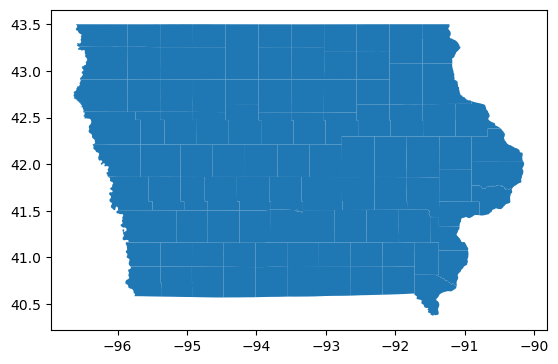

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt

#running the code to check if the graph is being generated
# Plot the shapefile data
df.plot()
plt.show()


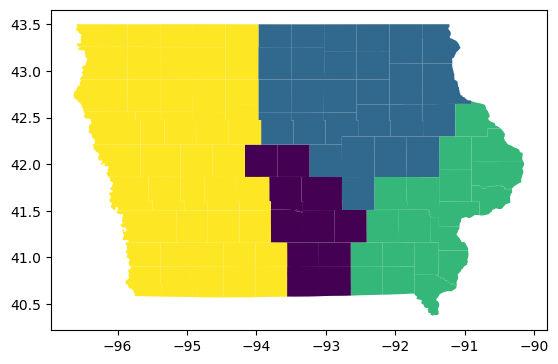

In [26]:
# To Which district each county is assigned to?
assignment = [ -1 for i in Gr.nodes ]

labeling = { i : j for i in Gr.nodes for j in range(k) if a[i,j].x > 0.5 }

# Now, add the assignments to a dataframe column and map it.
#node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# Check if the 'GEOID20' column exists in the DataFrame
if 'GEOID20' in df.columns:
    node_with_this_geoid = {row['GEOID20']: node for node, row in Gr.nodes(data=True)}

    # Loop through the DataFrame rows
    for u in range(len(df)):
        geoid = df.at[u, 'GEOID20']  # Access 'GEOID20' column for each row

        # Check if the geoid exists in the node_with_this_geoid dictionary
        if geoid in node_with_this_geoid:
            i = node_with_this_geoid[geoid]
            assignment[u] = labeling.get(i, -1)  # Assign district number or -1 if not found
        else:
            print(f"No node found in Gr for GEOID20: {geoid}")
else:
    print("Column 'GEOID20' not found in the DataFrame.")


# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment
#df.scatter(-60, -30, color='red', transform=ccrs.PlateCarree())
my_fig = df.plot(column='assignment').get_figure()